In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import difflib
import string
import time

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt
from matplotlib.table import Table

/home/dc7456ee-7004-4c58-beb5-f637147ef73b/.local/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Read and extract XSD elements

In [3]:
tag_meaning = {}
with open('TagsMeaning.txt', 'r', encoding='utf-8') as file:
    for line in file:
        if '==>' in line:
            tag, meaning = line.strip().split('==>')
            tag_meaning[tag.strip()] = meaning.strip()

In [4]:
def preprocess_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.lower().split()

def extract_tags(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    tags = {elem.tag for elem in root.iter()}
    return tags

def extract_xsd_elements(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    xsd_elements = []
    for element in root.iter('{http://www.w3.org/2001/XMLSchema}simpleType'):
        xsd_elements.append(element.attrib['name'])
    return xsd_elements

## Fuzzy Matching

In [9]:
def find_best_match(tag, meaning, xsd_elements):
    combined_text = " ".join(preprocess_text(tag) + preprocess_text(meaning))
    best_match, score = process.extractOne(combined_text, xsd_elements, scorer=fuzz.token_sort_ratio)
    return best_match, score

## Pairing data

In [12]:
def match_tags_with_xsd(tag_meaning, xsd_elements):
    matches = []
    for tag, meaning in tag_meaning.items():
        best_match, score = find_best_match(tag.strip(), meaning.strip(), xsd_elements)
        matches.append((tag, meaning, (best_match, score)))
    return matches

## Compare xml files

In [25]:
def calculate_similarity(tags1, tags2, tag_meaning):
    comparison_results = []
    
    for tag1 in tags1:
        best_match = None
        highest_similarity = 0
        meaning1 = tag_meaning.get(tag1, "Unknown")
        
        for tag2 in tags2:
            meaning2 = tag_meaning.get(tag2, "Unknown")
            
            tag_similarity = fuzz.ratio(tag1, tag2) / 100 
            meaning_similarity = fuzz.ratio(meaning1, meaning2) / 100
            
            combined_similarity = (tag_similarity + meaning_similarity) / 2
            
            if combined_similarity > highest_similarity:
                highest_similarity = combined_similarity
                best_match = tag2
        
        comparison_results.append({
            "Tag from File 1": tag1,
            "Meaning File 1": meaning1,
            "Best Match in File 2": best_match,
            "Meaning File 2": tag_meaning.get(best_match, "Unknown"),
            "Similarity Score": round(highest_similarity * 100, 2),
        })
    
    return pd.DataFrame(comparison_results)

def compute_overall_similarity(df):
    return df["Similarity Score"].mean()

def plot_similarity_scores(df):
    plt.figure(figsize=(10, 6))
    plt.barh(df["Tag from File 1"], df["Similarity Score"], color='blue', edgecolor='black')
    plt.xlabel("Similarity Score (%)")
    plt.ylabel("Tags from File 1")
    plt.title("Tag Similarity Scores Between Two XML Files")
    plt.tight_layout()
    plt.show()

## Plot results

In [18]:
def save_matches_to_csv(matches, output_file):

    data = [
        {
            "Tag": tag,
            "Meaning": meaning,
            "Best Match (XSD Element)": match[0] if match else "No Match",
            "Similarity (%)": f"{match[1]:.2f}%" if match else "0.00%"
        }
        for tag, meaning, match in matches
    ]
    

    df = pd.DataFrame(data)
    df['Similarity (%)'] = df['Similarity (%)'].str.rstrip('%').astype(float)  # Convert percentages to numeric for sorting
    sorted_df = df.sort_values(by="Similarity (%)", ascending=False)
    
    sorted_df.to_csv(output_file, index=False)
    
    print(f"Matches saved to '{output_file}' successfully.")


In [20]:
xml_file1 = "IPC-2581C.xsd"
xml_file2 = "test_1.xml"

tags_file1 = extract_tags(xml_file1)
tags_file2 = extract_tags(xml_file2)
elements_file1 = extract_xsd_elements(xml_file1)

Execution time overall similarity: 0.010516881942749023 seconds
Overall Similarity Score: 57.3%
Matches saved to 'fuzzy_matches_output.csv' successfully.
Execution time fuzzy matches: 0.4424715042114258 seconds


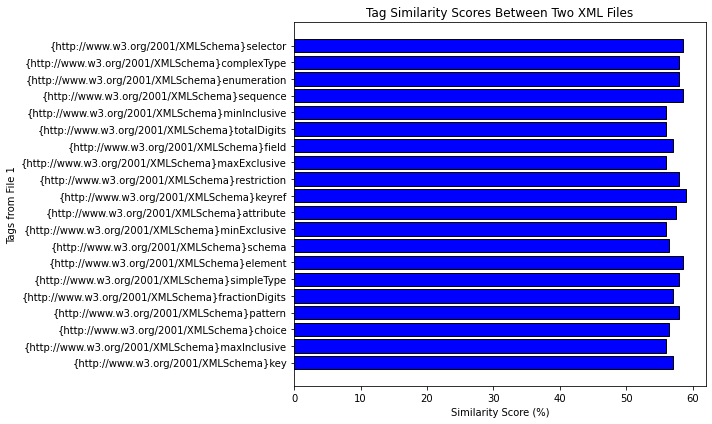

In [29]:
start_time = time.time()

comparison_df = calculate_similarity(tags_file1, tags_file2, tag_meaning)
overall_similarity = compute_overall_similarity(comparison_df)

end_time = time.time()
print(f"Execution time overall similarity: {end_time - start_time} seconds")
print(f"Overall Similarity Score: {round(overall_similarity, 2)}%")


start_time = time.time()

matches = match_tags_with_xsd(tag_meaning, elements_file1)
output_file = 'fuzzy_matches_output.csv'
save_matches_to_csv(matches, output_file)

end_time = time.time()
print(f"Execution time fuzzy matches: {end_time - start_time} seconds")

plot_similarity_scores(comparison_df)